# Initialize notebook

In [3]:
# Import libraries
import math
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import mean_squared_error
import time
from operator import is_not
from functools import partial
import statistics

In [4]:
# Constants
KITTI_DATASET = '/media/javier/HDD_linux/KITTI_dataset'

# Load dataframe

In [5]:
df = pd.read_csv (KITTI_DATASET+'/training/kitti_gt.csv')

In [19]:
df[:10]

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,x,y,z,ry,distance,heigth_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom
0,0,0,Pedestrian,0.0,0.0,-0.20,712.40,143.00,810.73,307.92,...,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False
1,1,0,Car,0.0,0.0,1.85,387.63,181.54,423.81,203.12,...,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False
2,1,1,Cyclist,0.0,3.0,-1.65,676.60,163.95,688.98,193.93,...,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False
3,2,0,Car,0.0,0.0,-1.67,657.39,190.13,700.07,223.39,...,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False
4,3,0,Car,0.0,0.0,1.55,614.24,181.78,727.31,284.77,...,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False
5,4,0,Car,0.0,0.0,1.96,280.38,185.10,344.90,215.59,...,-15.71,2.16,38.26,1.57,41.416148,30.49,64.52,-0.39,False,False
6,4,1,Car,0.0,0.0,1.88,365.14,184.54,406.11,205.20,...,-15.89,2.23,51.17,1.58,53.626802,20.66,40.97,-0.30,False,False
7,5,0,Pedestrian,0.0,0.0,1.94,330.06,178.74,360.77,238.64,...,-8.50,2.07,23.02,1.59,24.626313,59.90,30.71,-0.35,False,False
8,6,0,Car,0.0,2.0,-1.55,548.00,171.33,572.40,194.42,...,-2.72,0.82,48.22,-1.62,48.303615,23.09,24.40,-0.07,False,False
9,6,1,Car,0.0,0.0,-1.21,505.25,168.37,575.44,209.18,...,-2.61,1.13,31.73,-1.30,31.857211,40.81,70.19,-0.09,False,False


# Point Cloud projection

In [7]:
def get_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'/training/image_2/'+name+'.png'
    binary = KITTI_DATASET+'/training/velodyne/'+name+'.bin'
    with open(KITTI_DATASET+'/training/calib/'+name+'.txt','r') as f:
        calib = f.readlines()

    # P2 (3 x 4) for left eye (intrinsic matrix in homogeneous coordinates)
    P2 = np.matrix([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3,4)
    R0_rect = np.matrix([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
    R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
    Tr_velo_to_cam = np.matrix([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

    # read raw data from binary
    scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))
    points = scan[:, 0:3] # lidar xyz (front, left, up)
    # TODO: use fov filter? 
    velo = np.insert(points,3,1,axis=1).T
    velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
    
    cam = P2 * R0_rect * Tr_velo_to_cam * velo
    cam = np.delete(cam,np.where(cam[2,:]<0)[1],axis=1)
    # get u,v,z
    cam[:2] /= cam[2,:]
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # filter point out of canvas
    u,v,z = cam
    u_out = np.logical_or(u<0, u>IMG_W)
    v_out = np.logical_or(v<0, v>IMG_H)
    outlier = np.logical_or(u_out, v_out)
    cam = np.delete(cam,np.where(outlier),axis=1)
    return cam

In [42]:
def show_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'/training/image_2/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    cam = get_point_cloud_projected(image_id)
    # generate color map from depth
    u,v,z = cam
    plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
    plt.title(name)
    
    plt.show()

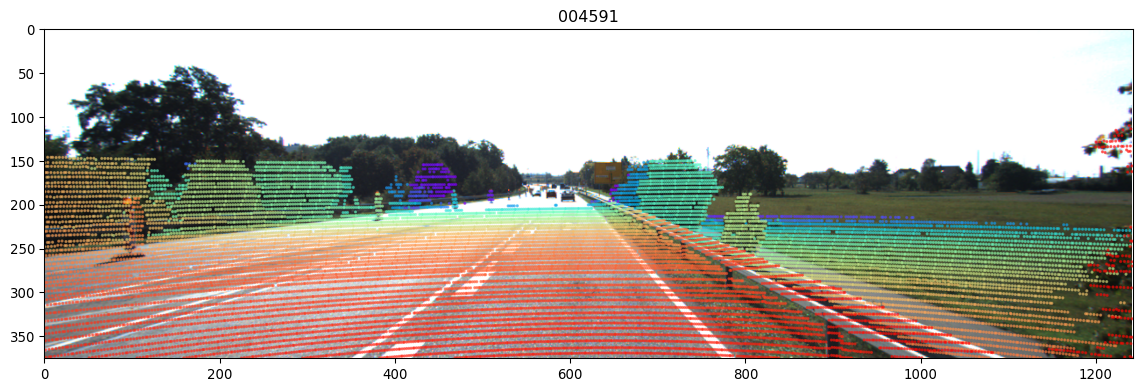

In [43]:
# Caso en el que la regresión no funcionaría correctamente
show_point_cloud_projected(4591)

# 2D bounding boxes

In [10]:
def get_bounding_boxes_2D(image_id):
    df_frame = df[df['frame'] == image_id]
    bbs = []
    for index, row in df_frame.iterrows():
        bb = (row['left'], row['top'], row['right'], row['bottom'])
        bbs.append(bb)
    return bbs

In [11]:
def show_bounding_boxes_2D(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'/training/image_2/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    # draw bounding boxes
    bbs = get_bounding_boxes_2D(image_id)
    for bb in bbs:
        plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
    
    # plt.savefig(KITTI_DATASET+'/training/projection/{name}.png',bbox_inches='tight')
    plt.show()

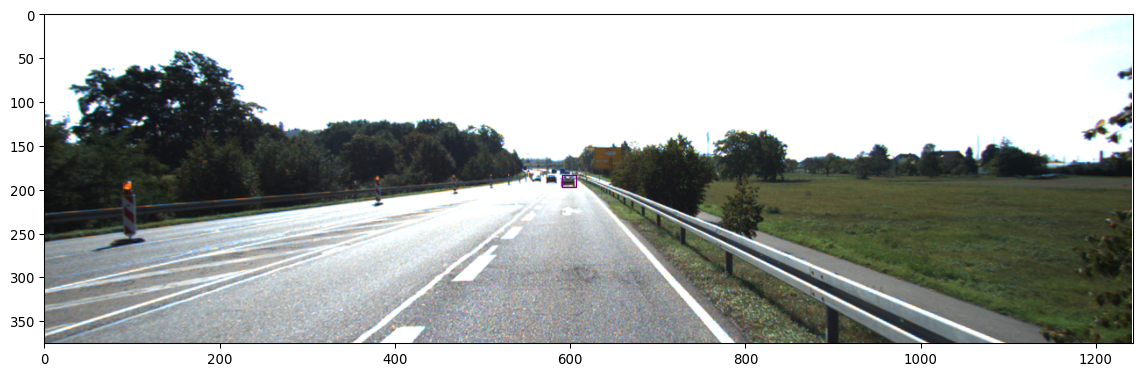

In [12]:
show_bounding_boxes_2D(4591)

# 1st distance approximation approach

In [13]:
def get_gt_distance(image_id):
    df_frame = df[df['frame'] == image_id]
    distances = []
    for index, row in df_frame.iterrows():
        distances.append(row['distance'])
    return distances

In [14]:
def get_distance_pc_projection(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    bbs_distance = [[],[]]
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            bbs_distance[0].append(bb)
            bbs_distance[1].append(distance)
    
    return bbs_distance

In [15]:
get_distance_pc_projection(4591)

[[], []]

In [16]:
def show_image_distance(image_id, bbs_distance):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'/training/image_2/'+name+'.png'
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    
    # show image
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    # draw bounding boxes
    gt_distances = get_gt_distance(image_id)
    if(len(bbs_distance[0]) > 0):
        bbs = bbs_distance[0]
        distances = bbs_distance[1]
        for bb, distance, gt_distance in zip(bbs, distances, gt_distances):
            plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
            plt.text(bb[0],bb[1],str(round(distance,2))+"m",color='green')
            plt.text(bb[0],bb[1]+10,str(round(gt_distance,2))+"m",color='red')
            print(distance)
            print(gt_distance)
            print("---")
        
    plt.show()

21.347484210385076
23.132768965257924
---
9.277864074916078
12.380020193844596
---
11.536538185454502
24.451570501708066
---
17.75203151953877
20.59929610447891
---
8.46334042892304
24.458064109818668
---
49.170257533254045
51.7871596054466
---
30.623028268190478
74.36600164053465
---


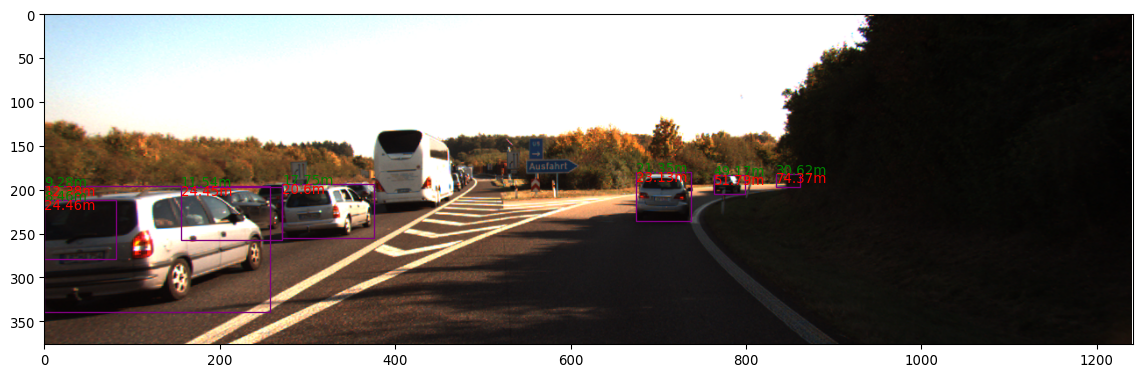

In [17]:
image_id = 7475
show_image_distance(image_id, get_distance_pc_projection(image_id))

In [18]:
def evaluate_mse_distances(bbs_distance_gt, bbs_distance_pred):
    y_true = []
    y_pred = []
    
    if(len(bbs_distance_pred[0]) == 0): # Checks if doesn't have any predictions
        return None
    else:
        for bb_gt, distance_gt in zip(bbs_distance_gt[0], bbs_distance_gt[1]): 
            for bb_pred, distance_pred in zip(bbs_distance_pred[0], bbs_distance_pred[1]):  
                if(bb_gt == bb_pred):
                    y_true.append(distance_gt)
                    y_pred.append(distance_pred)
                    break
        return mean_squared_error(y_true, y_pred)

In [29]:
def mse(frame):
    df_frame = df[df['frame'] == frame]
    bbs_distance_gt = [get_bounding_boxes_2D(frame),df_frame['distance']]
    mse_value = evaluate_mse_distances(bbs_distance_gt, get_distance_pc_projection(frame))
    return mse_value

occlusions = [0, 1, 2, 3]
text_occlusions = ["with level 0 of occlusion", "with level 1 of occlusion or less", "with level 2 of occlusion or less", "with level 3 of occlusion or less"]

for occlusion, text_occlusion in zip(occlusions, text_occlusions):
    df_occlusion = df[df['occluded'] <= occlusion]
    mse_by_frame = df_occlusion['frame'].unique()
    start_time = time.time()
    mse_by_frame = list(map(mse, mse_by_frame))
    print("--- %s seconds to calculate MSE %s ---" % (time.time() - start_time, text_occlusion))

    start_time = time.time()
    mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))
    print("--- %s seconds to eliminate None %s ---" % (time.time() - start_time, text_occlusion))

    start_time = time.time()
    mean_mse = statistics.mean(mse_by_frame_without_none)
    print("--- %s seconds calculate the mean of all frames %s ---" % (time.time() - start_time, text_occlusion))

    print("\nMean of all MSE by frame %s = %s\n" % (text_occlusion, mean_mse))

--- 126.69947123527527 seconds to calculate MSE with level 0 of occlusion ---
--- 0.0006415843963623047 seconds to eliminate None with level 0 of occlusion ---
--- 0.007298946380615234 seconds calculate the mean of all frames with level 0 of occlusion ---

Mean of all MSE by frame with level 0 of occlusion = 29.952635596737714

--- 133.5860025882721 seconds to calculate MSE with level 1 of occlusion or less ---
--- 0.0009248256683349609 seconds to eliminate None with level 1 of occlusion or less ---
--- 0.008620977401733398 seconds calculate the mean of all frames with level 1 of occlusion or less ---

Mean of all MSE by frame with level 1 of occlusion or less = 30.059061585816803

--- 132.16442370414734 seconds to calculate MSE with level 2 of occlusion or less ---
--- 0.0006747245788574219 seconds to eliminate None with level 2 of occlusion or less ---
--- 0.007323026657104492 seconds calculate the mean of all frames with level 2 of occlusion or less ---

Mean of all MSE by frame wit

# 2nd distance approximation approach

In [63]:
def get_intersection_between_rectangles(bb1, bb2):
    """
    bb: [left, top, right, bottom]
    """
    left = max(bb1[0], bb2[0])
    top = max(bb1[1], bb2[1])
    right = min(bb1[2], bb2[2])
    bottom = min(bb1[3], bb2[3])
    if left > right:
        return None
    if top > bottom:
        return None
    return [left, top, right, bottom]

In [194]:
def get_point_cloud_projected_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    n_bbs = len(bbs)
    for i in range(n_bbs):
        for j in range(i+1, n_bbs):
            intersection = get_intersection_between_rectangles(bbs[i], bbs[j])
            if (intersection != None):
                filter_intersection = (intersection[0] < projected_pc[0,:]) &\
                                      (intersection[1] < projected_pc[1,:]) &\
                                      (projected_pc[0,:] < intersection[2]) &\
                                      (projected_pc[1,:] < intersection[3])
#                 filter_intersection = np.squeeze(np.asarray(filter_intersection))
#                 a = [projected_pc[0,:][filter_intersection], projected_pc[1,:][filter_intersection],
#                                projected_pc[2,:][filter_intersection]]
                projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                               projected_pc[1,:][~filter_intersection],\
                                               projected_pc[2,:][~filter_intersection]), axis=0)
                
                
    return projected_pc

In [195]:
def show_point_cloud_projected_without_intersections(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'/training/image_2/'+name+'.png'
    
    # do projection staff
    plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # restrict canvas in range
    plt.axis([0,IMG_W,IMG_H,0])
    plt.imshow(png)
    
    cam = get_point_cloud_projected_without_intersections(image_id)
    # generate color map from depth
    u,v,z = cam
    plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
    plt.title(name)
    
    # draw bounding boxes
    bbs = get_bounding_boxes_2D(image_id)
    for bb in bbs:
        plt.gca().add_patch(Rectangle((bb[0], bb[1]),bb[2]-bb[0],bb[3]-bb[1],linewidth=1,edgecolor='purple',facecolor='none'))
    
    plt.show()

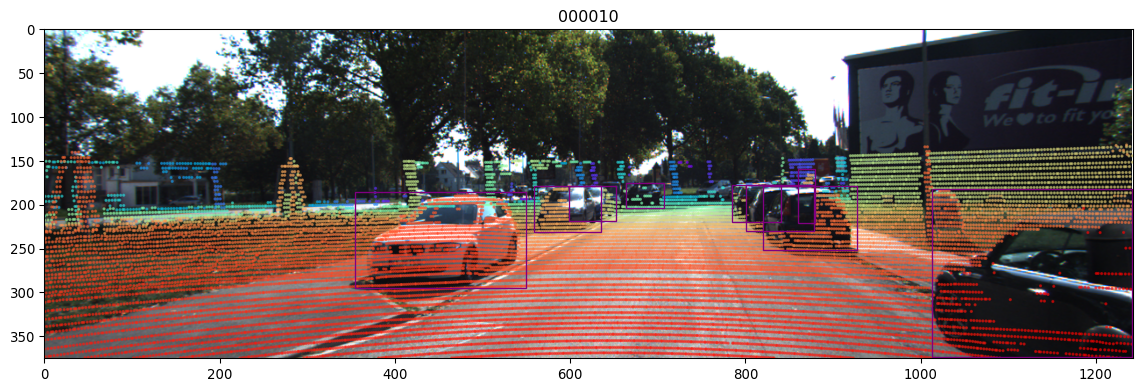

In [196]:
show_point_cloud_projected_without_intersections(10)

In [37]:
def get_distance_pc_projection(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    # Remove points in areas with bb insersections
    n_bbs = len(bbs)
    for i in range(n_bbs):
        for j in range(i+1, n_bbs):
            intersection = get_intersection_between_rectangles(bbs[i], bbs[j])
            if (intersection != None):
                filter_intersection = (intersection[0] > projected_pc[0,:]) & (intersection[1] > projected_pc[1,:]) &\
                                      (projected_pc[0,:] > intersection[2]) & (projected_pc[1,:] > intersection[3])
#                 projected_pc = projected_pc[2,:][filter_bb]
                projected_pc = projected_pc[:,filter_bb]
    
    bbs_distance = [[],[]]
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            bbs_distance[0].append(bb)
            bbs_distance[1].append(distance)
    
    return bbs_distance

In [23]:
df['occluded'].unique()

array([0., 3., 2., 1.])